<h1>Sommaire<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Contrôle-Python-de-la-console-Foxy" data-toc-modified-id="Contrôle-Python-de-la-console-Foxy-1">Contrôle Python de la console Foxy</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1">Introduction</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-1.2">Setup</a></span></li><li><span><a href="#Module-Foxy_Wallon" data-toc-modified-id="Module-Foxy_Wallon-1.3">Module Foxy_Wallon</a></span></li><li><span><a href="#Première-acquisition" data-toc-modified-id="Première-acquisition-1.4">Première acquisition</a></span></li><li><span><a href="#Visualisation-de-spectres" data-toc-modified-id="Visualisation-de-spectres-1.5">Visualisation de spectres</a></span></li><li><span><a href="#Echantillonnage" data-toc-modified-id="Echantillonnage-1.6">Echantillonnage</a></span></li><li><span><a href="#Filtrage-numérique" data-toc-modified-id="Filtrage-numérique-1.7">Filtrage numérique</a></span></li></ul></li></ul></div>

# Contrôle Python de la console Foxy

## Introduction

Il est désormais possible d'utiliser les données acquises par la console Foxy directement sur Python.

Nous disposons donc d'un Convertisseur Analogique Numérique performant, qui peut être couplé à toutes les manipulations de signaux disponibles sur Python. Cette fonctionnalité peut être pratique pour les TP orientés "numérique" (FFT, Filtrage numérique) et, surtout, pour le TIPE.

## Setup

- Connecter la console Foxy au PC
- Double cliquer sur le Lecteur CD : "Logiciels Foxy" qui apparaît dans "Ce PC"
- Aller dans le répetoire "W" et cliquer sur "lanceurfoxy"
- Cliquer sur l'icône Python

La console IDLE s'ouvre. A partir de là :
- on peut travailler en lignes de commande dans la console
- on peut cliquer sur "File-->New File" pour créer un fichier *.py* et travailler dans un éditeur. Pour exécuter le fichier, on cliquera sur "Run-->Run module" 

## Module Foxy_Wallon

Afin de faciliter l'acquisition de données de la console, un module ```foxy_wallon``` a été créé. Il faudra le placer dans le même répertoire que votre fichier Python de travail afin de pouvoir l'importer.

Il est constitué du code ci-dessous.

On importe déjà les bibliothèques utiles

In [ ]:
import JeulinLib # module spécifique pour communiquer avec la console
import matplotlib.pyplot as plt
import numpy as np

La fonction ```acquisition(voie,tf,N)``` va permettre de paramétrer l'acquisition. Elle prend en argument :
- la liste des voies de la Foxy que l'on veut acquérir. Par exemple : ```voie=[1,2,4]``` si on veut lire les voies 1, 2 et 4
- la durée ```tf```, réel en secondes, de l'acquisition
- le nombre de points ```N```de l'acquisition

Elle renvoie :
- la liste ```t``` des instants d'acquisition
- ```Y``` qui est une liste de liste : ```Y[0]``` contient la liste des valeurs de tensions de la première voie renseignée dans ```voie``` aux instants d'acquisition, ```Y[1]``` celle de la deuxième voie, etc...

In [1]:
def acquisition(voie, tf, N):
    "réalise l'acquisition de tension prise sur voie, pendant une durée tf, avec N points de mesure"
    "voie est une liste d'entiers correspondant aux voies à visualiser, N est un entier, tf un réel"
    
    # Connexion et Paramétrage
    bResultConnect = JeulinLib.Foxy_Connect() #connexion à la console
    if bResultConnect==False :
        print("Erreur de connexion à la console")
        return ...,...

    nb=len(voie)

    for i in range(nb):
        bResultCalibre =JeulinLib.Foxy_SetCalibre(str(voie[i]),0,0,3)
        if bResultCalibre==False :
            print("Erreur d'initialisation du calibre")
    
    dt=tf/N
    bResult = JeulinLib.Foxy_AcquisitionInit(tf,N) # paramètres acquisition
    if bResult==False :
        print("Erreur d'initialisation de l'acquisition")
        return ...,...
    
    
    # Sélection des voies qui seront acquises
    for i in range(nb):
        #print(i)
        zPort=str(voie[i])
        bResult2 = JeulinLib.Foxy_AcquisitionAdd(zPort,0)
        if bResult2==False:
            print("Erreur d'ajout de voie")
        
    # Lancement de l'acquisition
    Y=JeulinLib.Foxy_AcquisitionStart()
    if Y==None :
        print("Erreur d'acquisition")


    # Déconnexion
    JeulinLib.Foxy_Deconnect()

    t=np.linspace(0,tf,N)

    return t,Y





## Première acquisition

La fonction ```acquisition``` est disponible dans le fichier ```foxy_wallon```.
Le fichier *foxy_wallon.py* devra être placé dans le même répertoire que le fichier Python de travail.

Ci-dessous on présente l'acquisition de deux tensions, envoyées par un GBF sur les voies 1 et 2 de la console.

In [ ]:
import foxy_wallon as f

import matplotlib.pyplot as plt
import numpy as np

tf=0.005
N=1000

t,Y=f.acquisition([1,2],tf,N)

plt.plot(t,Y[0],label="CH1")
plt.plot(t,Y[1],label="CH2")

plt.legend()
plt.grid()
plt.xlabel("t en s")
plt.ylabel("tension en V")
plt.show()


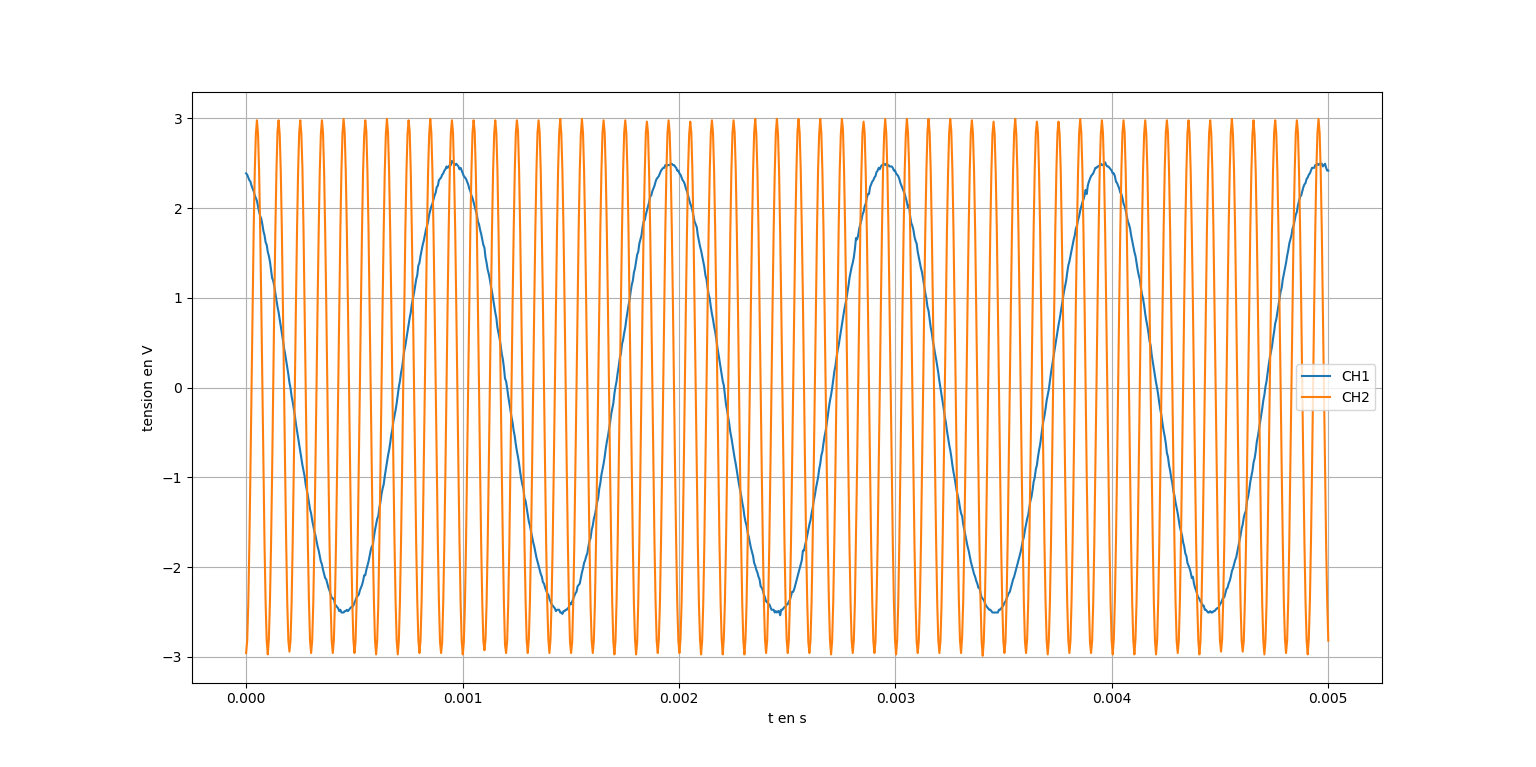

On visualise bien les deux sinusoïdes de fréquences différentes, placées sur les voies 1 et 2 de la console.



## Visualisation de spectres

On s'intéresse ici à la visualisation du spectre d'un signal carré de fréquence 1kHz à l'aide des fonctions du module ```fft```de ```numpy```. Ce signal est généré par un GBF et ici envoyé vers la voie 1.


In [ ]:
import foxy_wallon as f

import matplotlib.pyplot as plt
import numpy as np

tf=0.03
N=5000

t,Y=f.acquisition([1],tf,N)

# Tracé temporel
plt.figure()
plt.subplot(211)
plt.plot(t,Y[0],label="CH1")
plt.legend()
plt.grid()
plt.xlabel("t en s")
plt.ylabel("tension en V")

# Tracé du spectre
dt=t[1]-t[0]
n=t.size

freq=np.fft.rfftfreq(n,d=dt) #abscisses du spectre
spectre=np.fft.rfft(Y[0])*1/n #ordonnées, le 1/n permet de retrouver les amplitudes en V

plt.subplot(212)
plt.plot(freq,np.abs(spectre))
plt.xlabel("Fréquence en Hz")
plt.ylabel("Amplitude en V")

plt.grid()
plt.show()


Le tracé associé donne :

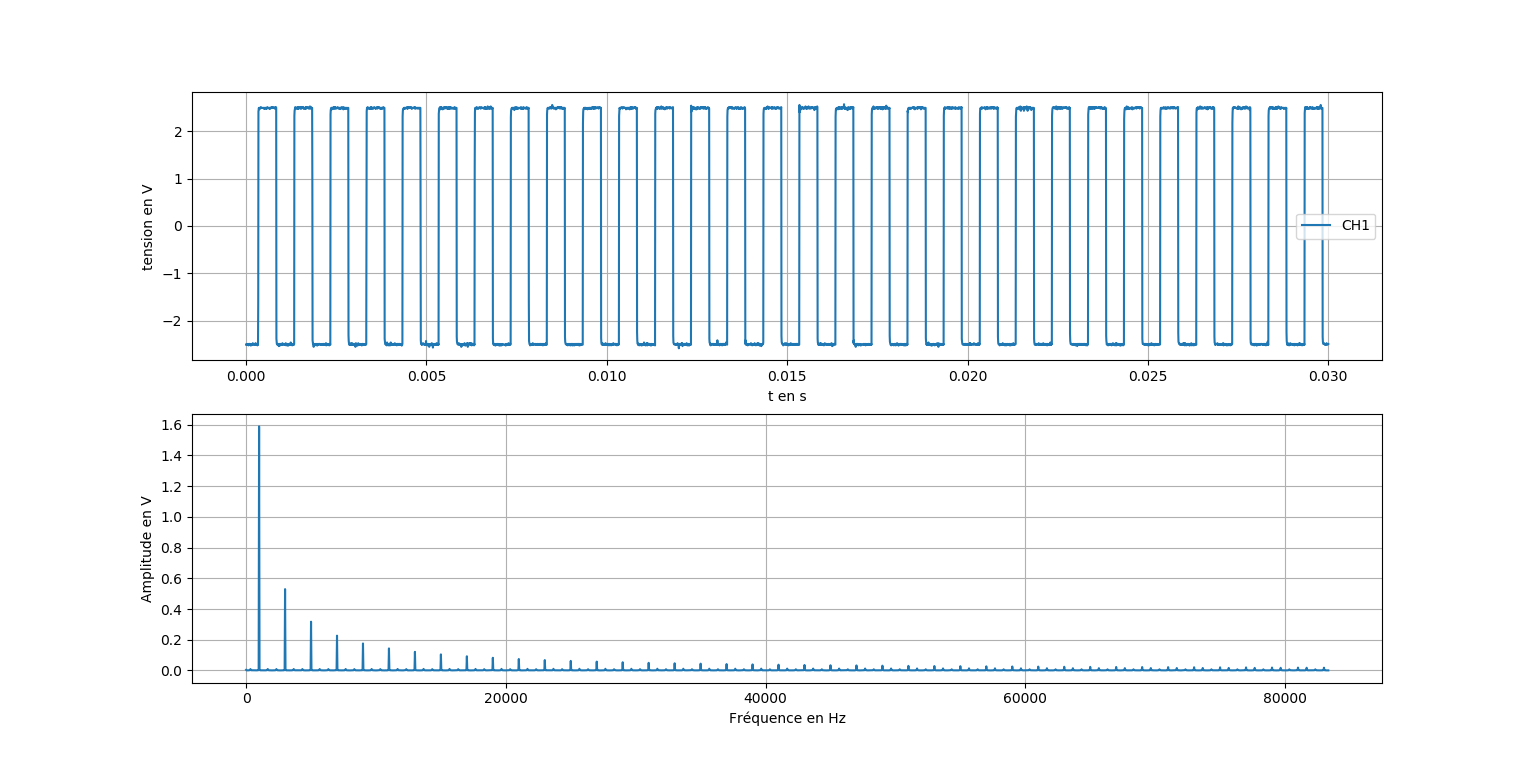

On retrouve bien le spectre du créneau et ses harmoniques de rang impair.

*Les plus attentifs auront remarqué que l'amplitude des raies est deux fois plus faible qu'attendue. Cela est dû à l'algorithme de FFT qui projette sur* $ e^{j\omega t}$ *et non sur* $\cos(\omega t)$ *, avec :*
$$\cos(\omega t) =\frac{e^{j\omega t} + e^{-j\omega t}}{2}$$
*On pourrait multiplier par 2 les amplitudes du spectre pour corriger... mais dans ce cas la valeur moyenne serait deux fois trop grande (ici, elle est nulle donc ce ne serait pas grave)*.

## Echantillonnage

On étudie ici l'échantillonnage d'une sinusoïde de fréquence 1kHz.
On peut mettre en évidence l'influence d'un non respect du théorème de Shannon.


In [ ]:
import foxy_wallon as f

import matplotlib.pyplot as plt
import numpy as np


## Shannon respecté

f_sig=1e3 #fréquence du signal
fe1=30e3
T=1/f_sig
Te1=1/fe1

tf=30*T
N=int(tf/Te1)
t1,Y1=f.acquisition([1],tf,N)

## Shannon non repecté

fe2=0.9e3
Te2=1/fe2
N2=int(tf/Te2)
t2,Y2=f.acquisition([1],tf,N2)



# Tracé temporel
plt.figure()
plt.subplot(211)
plt.title("Echantillonnage d'une sinusoïde de fréquence 1kHz")

plt.plot(t1,Y1[0],'*-',label="fe=30kHz")
plt.plot(t2,Y2[0],'*-',label="fe=0.9kHz")
plt.legend()
plt.grid()
plt.xlabel("t en s")
plt.ylabel("tension en V")


# Tracé du spectre
dt=t1[1]-t1[0]
n=t1.size
dt2=t2[1]-t2[0]
n2=t2.size

freq=np.fft.rfftfreq(n,d=dt) #abscisses du spectre
spectre=np.fft.rfft(Y1[0])*1/n #ordonnées, le 1/n permet de retrouver les amplitudes en V
freq2=np.fft.rfftfreq(n2,d=dt2) #abscisses du spectre
spectre2=np.fft.rfft(Y2[0])*1/n2

plt.subplot(212)
plt.plot(freq,np.abs(spectre),label="fe=30kHz")
plt.plot(freq2,np.abs(spectre2),label="fe=0.9kHz")
plt.xlabel("Fréquence en Hz")
plt.ylabel("Amplitude en V")




plt.grid()
plt.show()

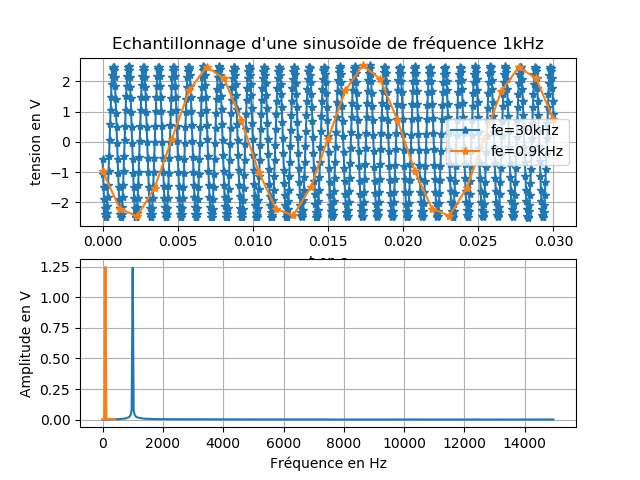

On retrouve bien le phénomène de repliement de spectre dans le domaine temporel et dans le domaine spectral.

*On a toujours le facteur 2 manquant dans les amplitudes du spectre*.

## Filtrage numérique

Ci-dessous la simulation numérique d'un passe-bas d'ordre 1.

In [ ]:
import foxy_wallon as f

import matplotlib.pyplot as plt
import numpy as np

tf=0.01
N=1000

Te=tf/N

tau=0.2e-3



t,Y=f.acquisition([1],tf,N)


#implémentation de la relation de récurrence
s=[0]
for i in range(1,N):
    s.append(s[i-1]+Te/tau*(Y[0][i-1]-s[i-1]))


# Tracé temporel
plt.figure()
plt.plot(t,Y[0],label="entrée")
plt.plot(t,s,label="sortie")
plt.legend()
plt.grid()
plt.xlabel("t en s")
plt.ylabel("tension en V")
plt.show()


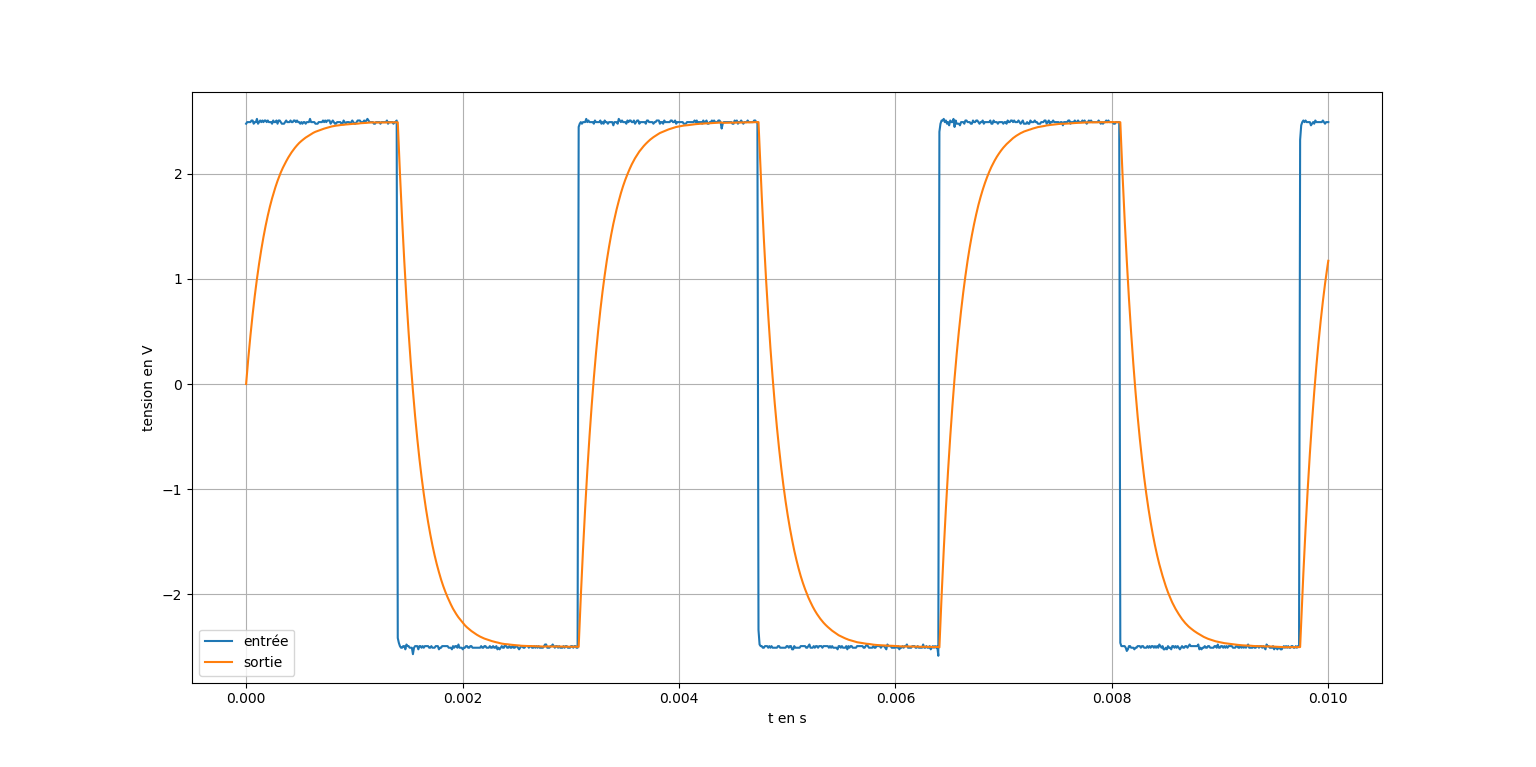

On a bien réalisé un passe-bas d'ordre 1, dont on retrouve le régime transitoire d'ordre 1 lorsqu'on le soumet à la réponse d'un créneau.